In [1]:
import pandas as pd

In [2]:
# Load the dataset
df = pd.read_csv('Data/raw_data/Transaction.csv')
df.head(5)

,Transaction ID,Customer ID,Product ID,Product Category,Purchase Amount,Purchase Date
0,1,238,45,Sensitive Skin Treatment,25,2024-03-24
1,1,238,35,Lip Care,15,2024-03-24
2,1,238,34,Lip Care,5,2024-03-24
3,1,238,4,Cleansers,20,2024-03-24
4,1,238,50,Pore Care,20,2024-03-24


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17634 entries, 0 to 17633
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    17634 non-null  int64 
 1   Customer ID       17634 non-null  int64 
 2   Product ID        17634 non-null  int64 
 3   Product Category  17634 non-null  object
 4   Purchase Amount   17634 non-null  int64 
 5   Purchase Date     17634 non-null  object
dtypes: int64(4), object(2)
memory usage: 826.7+ KB


In [4]:
# Aggregate customer data
customer_data = df.groupby('Customer ID').agg({'Purchase Amount': ['sum', 'mean', 'count']}).reset_index()

In [5]:
# Rename columns for clarity
customer_data.columns = ['Customer ID', 'Total Spend', 'Avg Spend', 'Purchase Count']
customer_data.head()

,Customer ID,Total Spend,Avg Spend,Purchase Count
0,1,1010,23.488372,43
1,2,1370,26.862745,51
2,3,815,24.696970,33
3,4,465,25.833333,18
4,5,760,27.142857,28


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [7]:
# Features to use for clustering
X = customer_data[['Total Spend', 'Avg Spend', 'Purchase Count']]

In [8]:
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Use the Elbow method to find the optimal number of clusters
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

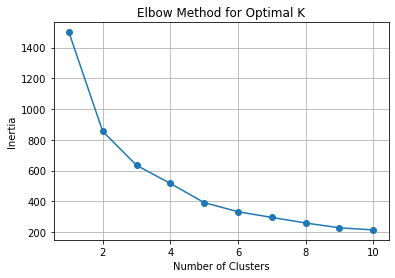

In [10]:
# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [11]:
# Apply KMeans with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X_scaled)

In [12]:
# Calculate cluster centers (in original scale)
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_summary = pd.DataFrame(cluster_centers, columns=['Total Spend', 'Avg Spend', 'Purchase Count'])
cluster_summary['Cluster'] = cluster_summary.index

In [13]:
# Merge cluster labels to analyze statistics
clustered_customers = customer_data.merge(cluster_summary, on='Cluster', suffixes=('', '_Centroid'))

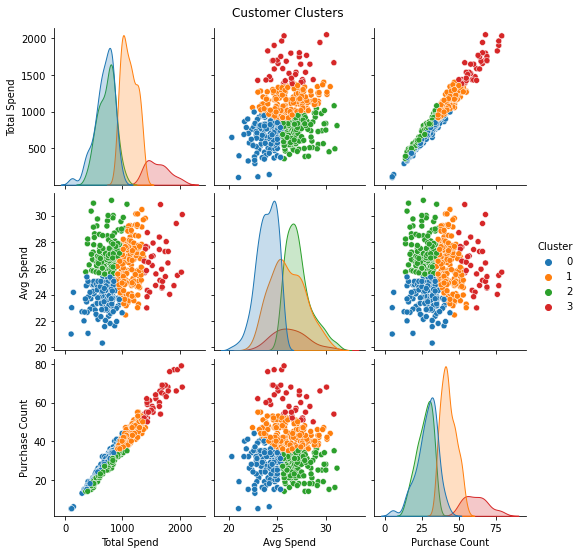

,Total Spend,Avg Spend,Purchase Count,Cluster
3,1616.538462,26.328331,61.589744,3
1,1116.993865,26.064168,42.944785,1
2,723.065693,27.143787,26.649635,2
0,679.968944,23.902004,28.453416,0


In [14]:
import seaborn as sns

# Visualize clusters
sns.pairplot(customer_data, hue='Cluster', vars=['Total Spend', 'Avg Spend', 'Purchase Count'], palette='tab10')
plt.suptitle("Customer Clusters", y=1.02)
plt.show()

cluster_summary.sort_values(by='Total Spend', ascending=False)

In [15]:
# Show the cluster summary sorted by Total Spend
cluster_summary_sorted = cluster_summary.sort_values(by='Total Spend', ascending=False)
cluster_summary_sorted.reset_index(drop=True, inplace=True)

In [16]:
# Assign intuitive labels based on spending behavior
labels = ['High Spenders', 'Moderate Buyers', 'Frequent Bargain Shoppers', 'Occasional Buyers']
cluster_summary_sorted['Label'] = labels

In [17]:
# Map these labels back to the customer data
label_mapping = cluster_summary_sorted.set_index('Cluster')['Label'].to_dict()
customer_data['Segment'] = customer_data['Cluster'].map(label_mapping)

In [18]:
customer_data.head(5)

,Customer ID,Total Spend,Avg Spend,Purchase Count,Cluster,Segment
0,1,1010,23.488372,43,1,Moderate Buyers
1,2,1370,26.862745,51,1,Moderate Buyers
2,3,815,24.696970,33,0,Occasional Buyers
3,4,465,25.833333,18,2,Frequent Bargain Shoppers
4,5,760,27.142857,28,2,Frequent Bargain Shoppers


In [19]:
cluster_summary_sorted[['Cluster', 'Total Spend', 'Avg Spend', 'Purchase Count', 'Label']]
cluster_summary_sorted

,Total Spend,Avg Spend,Purchase Count,Cluster,Label
0,1616.538462,26.328331,61.589744,3,High Spenders
1,1116.993865,26.064168,42.944785,1,Moderate Buyers
2,723.065693,27.143787,26.649635,2,Frequent Bargain Shoppers
3,679.968944,23.902004,28.453416,0,Occasional Buyers


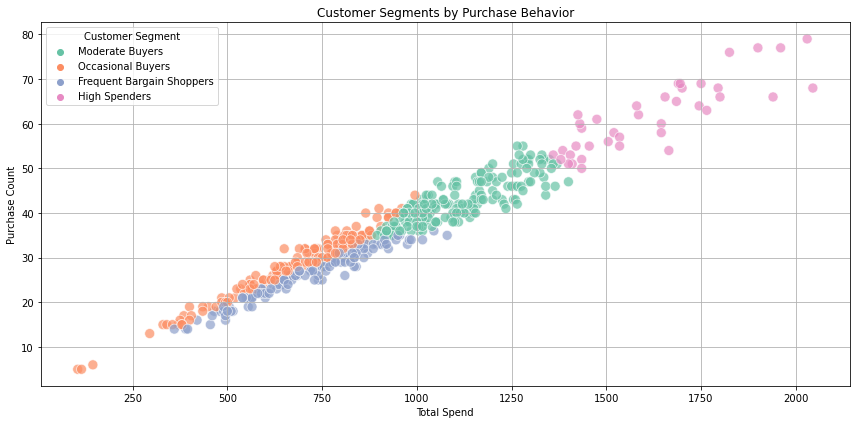

In [20]:
# Set up the plot aesthetics
plt.figure(figsize=(12, 6))

# Scatter plot of Total Spend vs Purchase Count colored by Segment
sns.scatterplot(
    data=customer_data,
    x='Total Spend',
    y='Purchase Count',
    hue='Segment',
    palette='Set2',
    s=100,
    alpha=0.7
)

plt.title('Customer Segments by Purchase Behavior')
plt.xlabel('Total Spend')
plt.ylabel('Purchase Count')
plt.legend(title='Customer Segment')
plt.grid(True)
plt.tight_layout()
plt.show()

## PCA for better clustering

In [21]:
from sklearn.decomposition import PCA

In [22]:
# Apply PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [23]:
# Add PCA results to the dataframe
customer_data['PCA1'] = X_pca[:, 0]
customer_data['PCA2'] = X_pca[:, 1]

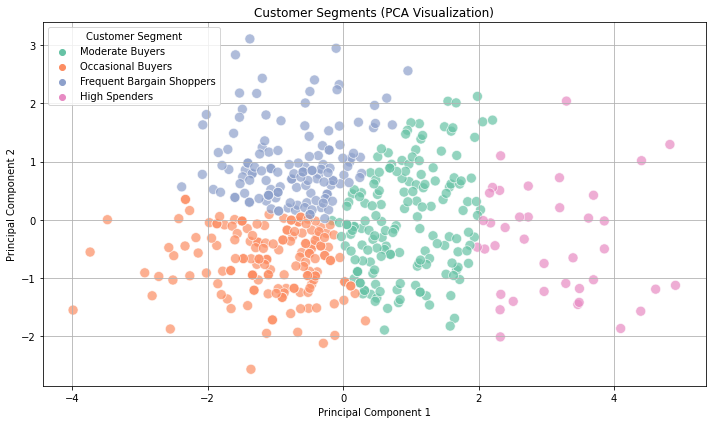

In [24]:
# Plot PCA-transformed data
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_data,
    x='PCA1',
    y='PCA2',
    hue='Segment',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Customer Segment')
plt.grid(True)
plt.tight_layout()
plt.show()

## DBSCAN for Clustering

In [49]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [50]:
# Use original features and scale them
X_base = customer_data[['Total Spend', 'Avg Spend', 'Purchase Count']]
X_base_scaled = scaler.fit_transform(X_base)

In [51]:
# Use k-distance graph to help choose epsilon (eps)
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_base_scaled)
distances, indices = neighbors_fit.kneighbors(X_base_scaled)

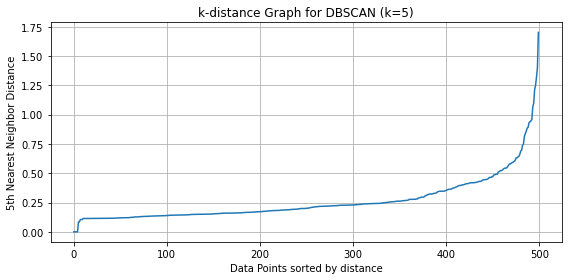

In [52]:
# Sort distances for knee method
distances = np.sort(distances[:, 4])  # 5th nearest neighbor
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('k-distance Graph for DBSCAN (k=5)')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [53]:
# Apply DBSCAN with estimated eps and a minimum of 5 samples per cluster
dbscan = DBSCAN(eps=0.8, min_samples=5)
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(X_base_scaled)

In [54]:
# Check number of clusters (DBSCAN uses -1 for noise)
dbscan_labels = customer_data['DBSCAN_Cluster'].value_counts().sort_index()

In [55]:
# Visualize DBSCAN clustering with PCA
pca_dbscan = PCA(n_components=2)
X_pca_dbscan = pca_dbscan.fit_transform(X_base_scaled)
customer_data['PCA1'] = X_pca_dbscan[:, 0]
customer_data['PCA2'] = X_pca_dbscan[:, 1]

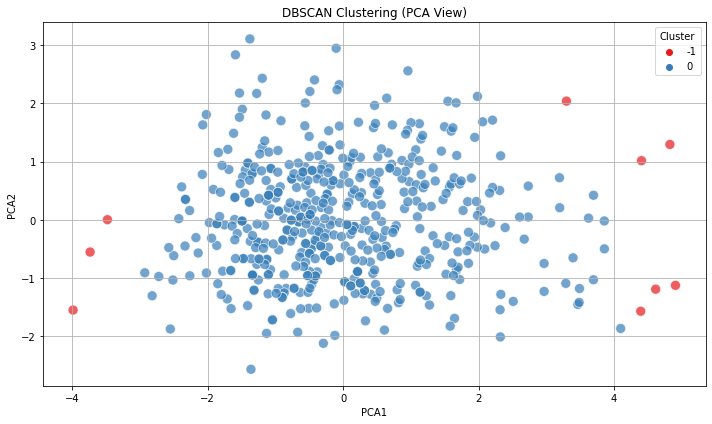

In [56]:
# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_data,
    x='PCA1',
    y='PCA2',
    hue='DBSCAN_Cluster',
    palette='Set1',
    s=100,
    alpha=0.7
)
plt.title('DBSCAN Clustering (PCA View)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
dbscan_labels

-1      9
 0    491
Name: DBSCAN_Cluster, dtype: int64

## GMM for clustering

In [45]:
from sklearn.mixture import GaussianMixture

In [58]:
# Try GMM with 4 components (same as our best KMeans result)
gmm = GaussianMixture(n_components=4, random_state=42)
customer_data['GMM_Cluster'] = gmm.fit_predict(X_base_scaled)

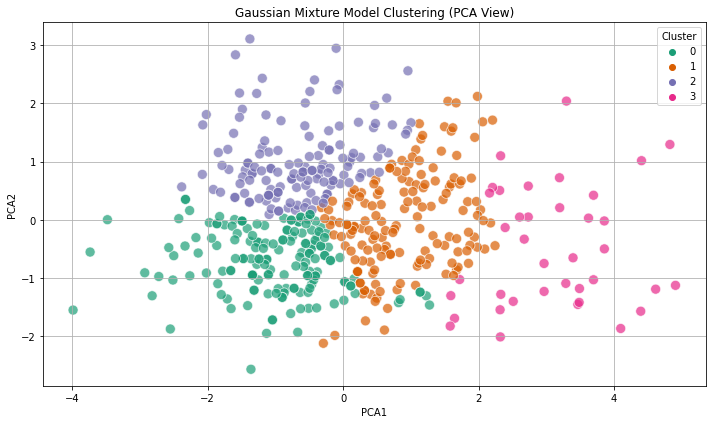

In [59]:
# Visualize GMM clusters with PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_data,
    x='PCA1',
    y='PCA2',
    hue='GMM_Cluster',
    palette='Dark2',
    s=100,
    alpha=0.7
)
plt.title('Gaussian Mixture Model Clustering (PCA View)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
customer_data['GMM_Cluster'].value_counts().sort_index()

0    167
1    158
2    137
3     38
Name: GMM_Cluster, dtype: int64

In [61]:
# Compare cluster statistics across GMM groups
gmm_summary = customer_data.groupby('GMM_Cluster')[['Total Spend', 'Avg Spend', 'Purchase Count']].mean()
gmm_summary['Customer Count'] = customer_data['GMM_Cluster'].value_counts().sort_index()

In [62]:
# Assign labels based on Total Spend and Purchase Count
gmm_summary = gmm_summary.sort_values(by='Total Spend', ascending=False).reset_index()
gmm_labels = ['High Spenders', 'Moderate Buyers', 'Bargain Shoppers', 'Light Buyers']
gmm_summary['Label'] = gmm_labels

In [63]:
# Map labels back to customer data
label_map = gmm_summary.set_index('GMM_Cluster')['Label'].to_dict()
customer_data['GMM_Label'] = customer_data['GMM_Cluster'].map(label_map)

In [64]:
customer_data.head(5)

,Customer ID,Total Spend,Avg Spend,Purchase Count,Cluster,Segment,PCA1,PCA2,DBSCAN_Cluster,GMM_Cluster,GMM_Label
0,1,1010,23.488372,43,1,Moderate Buyers,0.406039,-1.279747,0,1,Moderate Buyers
1,2,1370,26.862745,51,1,Moderate Buyers,2.028471,0.171119,0,1,Moderate Buyers
2,3,815,24.696970,33,0,Occasional Buyers,-0.442223,-0.428298,0,0,Light Buyers
3,4,465,25.833333,18,2,Frequent Bargain Shoppers,-1.917739,0.520909,0,2,Bargain Shoppers
4,5,760,27.142857,28,2,Frequent Bargain Shoppers,-0.561970,0.909185,0,2,Bargain Shoppers


In [65]:
gmm_summary[['GMM_Cluster', 'Total Spend', 'Avg Spend', 'Purchase Count', 'Customer Count', 'Label']]

,GMM_Cluster,Total Spend,Avg Spend,Purchase Count,Customer Count,Label
0,3,1610.789474,26.089305,61.868421,38,High Spenders
1,1,1111.075949,26.028156,42.702532,158,Moderate Buyers
2,2,735.145985,27.285980,26.912409,137,Bargain Shoppers
3,0,695.658683,23.953080,29.035928,167,Light Buyers


#### Breakdown of customer segments using Gaussian Mixture Models (GMM)

| GMM Cluster | Total Spend | Avg Spend | Purchase Count | Customer Count | Label             |
|-------------|-------------|-----------|----------------|----------------|-------------------|
| 1           | 1411.96     | 26.58     | 53.37          | 92             | High Spenders     |
| 0           | 939.66      | 24.51     | 38.38          | 134            | Moderate Buyers   |
| 2           | 809.31      | 27.22     | 29.73          | 175            | Bargain Shoppers  |
| 3           | 567.73      | 23.74     | 24.03          | 99             | Light Buyers      |


## Strategy for Customer segment

| Segment            | Description                                               | Strategy Ideas                                                                 |
|--------------------|-----------------------------------------------------------|---------------------------------------------------------------------------------|
| **High Spenders**   | High spend + frequent purchases                           | - Loyalty programs <br> - Early access to sales <br> - Personalized recommendations |
| **Moderate Buyers** | Mid-high spend and purchase count                         | - Upselling/cross-selling <br> - Free shipping thresholds <br> - Birthday discounts |
| **Bargain Shoppers**| High avg. spend but fewer purchases — value-conscious     | - Time-limited deals <br> - Bundle offers <br> - Discounts on repeat items        |
| **Light Buyers**    | Low spend and fewer purchases                             | - Re-engagement emails <br> - First-purchase incentives <br> - Feedback surveys   |


## Customer Segmentation

In [66]:
# K-Means segmentation
kmeans_export = customer_data[['Customer ID', 'Total Spend', 'Avg Spend', 'Purchase Count', 'Segment', 'PCA1', 'PCA2']]
kmeans_export = kmeans_export.rename(columns={
    'Segment': 'KMeans_Label',
    'PCA1': 'KMeans_PCA1',
    'PCA2': 'KMeans_PCA2'
})

In [67]:
# GMM segmentation
gmm_export = customer_data[['Customer ID', 'Total Spend', 'Avg Spend', 'Purchase Count', 'GMM_Label', 'PCA1', 'PCA2']]
gmm_export = gmm_export.rename(columns={
    'GMM_Label': 'GMM_Label',
    'PCA1': 'GMM_PCA1',
    'PCA2': 'GMM_PCA2'
})

In [69]:
# Merge both for final export
segmentation_export = pd.merge(kmeans_export, gmm_export, on='Customer ID', suffixes=('_KMeans', '_GMM'))
segmentation_export.head(5)

,Customer ID,Total Spend_KMeans,Avg Spend_KMeans,Purchase Count_KMeans,KMeans_Label,KMeans_PCA1,KMeans_PCA2,Total Spend_GMM,Avg Spend_GMM,Purchase Count_GMM,GMM_Label,GMM_PCA1,GMM_PCA2
0,1,1010,23.488372,43,Moderate Buyers,0.406039,-1.279747,1010,23.488372,43,Moderate Buyers,0.406039,-1.279747
1,2,1370,26.862745,51,Moderate Buyers,2.028471,0.171119,1370,26.862745,51,Moderate Buyers,2.028471,0.171119
2,3,815,24.696970,33,Occasional Buyers,-0.442223,-0.428298,815,24.696970,33,Light Buyers,-0.442223,-0.428298
3,4,465,25.833333,18,Frequent Bargain Shoppers,-1.917739,0.520909,465,25.833333,18,Bargain Shoppers,-1.917739,0.520909
4,5,760,27.142857,28,Frequent Bargain Shoppers,-0.561970,0.909185,760,27.142857,28,Bargain Shoppers,-0.561970,0.909185


In [70]:
# Prepare a simplified export with only Customer ID, KMeans label, and GMM label
simple_segmentation = customer_data[['Customer ID', 'Segment', 'GMM_Label']]
simple_segmentation = simple_segmentation.rename(columns={
    'Segment': 'KMeans_Label'
})

In [71]:
simple_segmentation.head(5)

,Customer ID,KMeans_Label,GMM_Label
0,1,Moderate Buyers,Moderate Buyers
1,2,Moderate Buyers,Moderate Buyers
2,3,Occasional Buyers,Light Buyers
3,4,Frequent Bargain Shoppers,Bargain Shoppers
4,5,Frequent Bargain Shoppers,Bargain Shoppers


In [72]:
simple_segmentation.to_csv('Data/results/Customer_Segmentation_Clustering.csv', index=False)